# Tanmay Garg
## CS20BTECH11063
## Deep Learning Assignment 4

In [45]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
import torch.functional as F
import torch.nn as nn
from sklearn.utils import shuffle
import PIL
from PIL import Image
import cv2
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim

np.random.seed(0)

## Data Generation

In [46]:
def generate_data(length=5, debug=False):
    # value of x lies between 0 and 1
    x = np.random.rand(length)
    if debug:
        print(x)
    
    # choose 2 indices randomly
    indices = np.random.choice(length, 2, replace=False)
    # print(indices)
    
    # create a mask of zeros
    mask = np.zeros(length)
    # print(mask)
    
    # set the mask values at the indices to 1
    mask[indices] = 1
    if debug:
        print(mask)
    
    # multiply the mask with the x
    y = x * mask
    y = np.sum(y)
    
    # combine x and mask to form the input
    x = np.stack([x, mask], axis=0)

    return x, y

x, y = generate_data(debug=False)
print(x)
print(y)

[[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ]
 [0.         1.         0.         1.         0.        ]]
1.2600725493693163


In [47]:
# generate 5000 samples of x and y using the above function and store them in a list but each of different length

X_data = []
Y_data = []

for i in range(6250):
    x, y = generate_data(np.random.randint(8, 15))
    X_data.append(x)
    Y_data.append(y)

# Split the data randomly into train and test sets with ratio r

def split_data(X_data, Y_data, r=0.8):
    # shuffle the data
    X_data, Y_data = shuffle(X_data, Y_data)
    
    # split the data
    split_index = int(len(X_data) * r)
    X_train = X_data[:split_index]
    Y_train = Y_data[:split_index]
    X_test = X_data[split_index:]
    Y_test = Y_data[split_index:]
    
    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_val, Y_val = split_data(X_data, Y_data)
X_val, Y_val, X_test, Y_test = split_data(X_val, Y_val)

print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))
print(len(X_test), len(Y_test))


5000 5000
1000 1000
250 250


## Baseline Model

In [48]:
# Baseline model always predicts the sum 1 regardless of any input
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
    
    def forward(self, x):
        return torch.ones(1, 1)
    
    def predict(self, x):
        return self.forward(x)
    

In [49]:
baseline = BaselineModel()
baseline.eval()

# Calculate the loss for input of X_val
baseline_loss_class = nn.MSELoss()
total_baseline_loss = 0
for i in range(len(X_val)):
    # print("Test sample: ", i)
    # print("X_val: ", X_val[i].shape)
    # print("Y_test: ", Y_test[i])
    # print(X_val[i])
    x = torch.from_numpy(X_val[i]).float()
    # print(x, x.shape)
    y = torch.from_numpy(np.array(Y_val[i])).float()
    # print(y, y.shape)
    y = y.view(1, 1)
    # print(y, y.shape)
    y_pred = baseline.predict(x)
    baseline_loss = baseline_loss_class(y_pred, y)
    total_baseline_loss += baseline_loss
    # print("For sample: Y_pred: ", y_pred, " Y_test: ", y, " Loss: ", baseline_loss)
    # print(baseline_loss)

print("Total baseline loss: ", total_baseline_loss.item())
print("Average baseline loss: ", total_baseline_loss.item() / len(X_val))
avg_baseline_loss = total_baseline_loss.item() / len(X_val)

# Calculate loss for input of X_test
total_baseline_loss = 0
for i in range(len(X_test)):
    # print("Test sample: ", i)
    # print("X_test: ", X_test[i].shape)
    # print("Y_test: ", Y_test[i])
    # print(X_test[i])
    x = torch.from_numpy(X_test[i]).float()
    # print(x, x.shape)
    y = torch.from_numpy(np.array(Y_test[i])).float()
    # print(y, y.shape)
    y = y.view(1, 1)
    # print(y, y.shape)
    y_pred = baseline.predict(x)
    baseline_loss = baseline_loss_class(y_pred, y)
    total_baseline_loss += baseline_loss
    # print("For sample: Y_pred: ", y_pred, " Y_test: ", y, " Loss: ", baseline_loss)
    # print(baseline_loss)

print("Total baseline loss (Test): ", total_baseline_loss.item())
print("Average baseline loss (Test): ", total_baseline_loss.item() / len(X_test))
avg_baseline_loss_test = total_baseline_loss.item() / len(X_test)

Total baseline loss:  169.68283081054688
Average baseline loss:  0.1696828308105469
Total baseline loss (Test):  37.494712829589844
Average baseline loss (Test):  0.14997885131835936


## Elmon RNN Model

In [50]:
class ElmonNet(nn.Module):
    def __init__(self):
        super(ElmonNet, self).__init__()
        
        # Linear Layers for converting input to hidden state
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 3)
        
        # hidden state weight
        self.hidden_weight = nn.Linear(3,1)
        
        # Prediction weight
        self.pred_weight = nn.Linear(3,1)
        self.softmax_layer = nn.Softmax(dim=1)
        self.tanh_layer = nn.Tanh()
        self.hidden_out = 0
    
    def hidden_forward(self, x, hidden_out):
        # out = torch.relu(self.fc1(x))
        # out = torch.relu(self.fc2(out))
        # out = self.tanh_layer(out + torch.relu(self.hidden_weight(hidden_out)))
        # print("X: ", x.shape)
        temp = (self.fc1(x))
        temp1 = (self.fc2(temp))
        # print("Hidden out: ", out.shape)
        # print("hide: ", hidden_out.shape)
        # print("Hidden out: ", out.shape)
        out = torch.tanh(temp1 + (self.hidden_weight(hidden_out)))
        
        return out
    
    def pred_forward(self, x):
        out = self.pred_weight(x)
        # out = self.softmax_layer(out)
        return out
    
    # def hidden_forward(self, x, hidden_out):
    #     out = torch.relu(self.fc1(x))
    #     out = torch.relu(self.fc2(out))
    #     self.hidden_out = out
    #     return out
    
    # def pred_forward(self, x):
    #     out = self.pred_weight(x)
    #     out = self.softmax_layer(out)
    #     return out
    
    # def forward(self, x):
    #     x = torch.relu(self.fc1(x))
    #     x = torch.relu(self.fc2(x))
    #     return x
    
    # def predict(self, x):
    #     return self.forward(x)

In [51]:
# def train_elmon(model, X_train, Y_train, X_val, Y_val, num_epochs=50):
#     loss = nn.MSELoss()
#     optimizer = optim.SGD(model.parameters(), lr=0.0001)

#     best_val_loss = float('inf')
#     best_model = None
    
#     for epoch in range(num_epochs):
#         epoch_train_loss = 0
#         epoch_val_loss = 0

#         # Training
#         model.train()
#         for j in range(len(X_train)):
#             x = torch.from_numpy(X_train[j]).float()
#             y = torch.from_numpy(np.array(Y_train[j])).float()
#             y = y.view(1, 1)
#             hidden_out = torch.zeros(3)
#             total_loss = 0
            
#             for k in range(x.shape[1]):
#                 hidden_out2 = model.hidden_forward(x[:, k], hidden_out)
#                 y_pred = model.pred_forward(hidden_out2)
#                 y_true = torch.dot(x[0, :(k+1)], x[1, :(k+1)])
#                 loss_val = loss(y_pred, y_true)
#                 total_loss += loss_val
#                 optimizer.zero_grad()
#                 loss_val.backward(retain_graph=True)
#                 # optimizer.step()
#                 hidden_out = hidden_out2
#             optimizer.step()
#             epoch_train_loss += total_loss

#         # Validation
#         with torch.no_grad():
#             model.eval()
#             # print("Training: ", model.training)
#             for i in range(len(X_val)):
#                 x = torch.from_numpy(X_val[i]).float()
#                 y = torch.from_numpy(np.array(Y_val[i])).float()
#                 y = y.view(1, 1)
#                 hidden_out = torch.zeros(3)
#                 total_loss = 0
#                 pred_val = 0

#                 for k in range(x.shape[1]):
#                     hidden_out2 = model.hidden_forward(x[:, k], hidden_out)
#                     y_pred = model.pred_forward(hidden_out2)
#                     pred_val = y_pred
#                     y_true = torch.dot(x[0, :(k+1)], x[1, :(k+1)])
#                     # loss_val = loss(y_pred, y_true)
#                     # total_loss += loss_val
#                     hidden_out = hidden_out2
#                 total_loss = loss(pred_val, y)
#                 epoch_val_loss += total_loss

#             # Save best model
#             if epoch_val_loss < best_val_loss:
#                 best_val_loss = epoch_val_loss
#                 best_model = model.state_dict()

#         # Print loss for current epoch
#         print(f"Epoch {epoch+1} Train Loss: {epoch_train_loss:.4f} Val Loss: {epoch_val_loss:.4f} Avg Train Loss: {epoch_train_loss/len(X_train):.4f} Avg Val Loss: {epoch_val_loss/len(X_val):.4f}")

#     # Load best model
#     model.load_state_dict(best_model)

#     # Print all the weights and biases
#     print(model.fc1.weight)
#     print(model.fc1.bias)
#     print(model.fc2.weight)
#     print(model.fc2.bias)
#     print(model.hidden_weight.weight)
#     print(model.hidden_weight.bias)
#     print(model.pred_weight.weight)
#     print(model.pred_weight.bias)

#     return model

# elmon_model = ElmonNet()
# # print(X_train, Y_train, X_test, Y_test)
# best_model = train_elmon(elmon_model, X_train, Y_train, X_test, Y_test) 
# best_model.eval()
# # test the model
# loss = nn.MSELoss()
# min_y_test = min(Y_test)
# max_y_test = max(Y_test)
# min_y_pred = 2
# max_y_pred = 0
# for i in range(len(X_test)):
#     x = torch.from_numpy(X_test[i]).float()
#     y = torch.from_numpy(np.array(Y_test[i])).float()
#     y = y.view(1, 1)
#     hidden_out = torch.zeros(3)
#     total_loss = 0
#     pred_val = 0

#     for k in range(x.shape[1]):
#         hidden_out2 = best_model.hidden_forward(x[:, k], hidden_out)
#         y_pred = best_model.pred_forward(hidden_out2)
#         pred_val = y_pred
#         y_true = torch.dot(x[0, :(k+1)], x[1, :(k+1)])
#         # loss_val = loss(y_pred, y_true)
#         # total_loss += loss_val
#         hidden_out = hidden_out2
#     total_loss = loss(pred_val, y)
#     if pred_val > max_y_pred:
#         max_y_pred = pred_val
#     if pred_val < min_y_pred:
#         min_y_pred = pred_val
#     print("For sample: Y_pred: ", pred_val, " Y_test: ", y, " Loss: ", total_loss)

# print("Min Y_pred: ", min_y_pred, " Max Y_pred: ", max_y_pred)
# print("Min Y_test: ", min_y_test, " Max Y_test: ", max_y_test)

Epoch 1 Train Loss: 922.8420 Val Loss: 171.2405 Avg Train Loss: 0.1846 Avg Val Loss: 0.1712
Epoch 2 Train Loss: 822.6434 Val Loss: 170.8012 Avg Train Loss: 0.1645 Avg Val Loss: 0.1708
Epoch 3 Train Loss: 820.6493 Val Loss: 170.4495 Avg Train Loss: 0.1641 Avg Val Loss: 0.1704
Epoch 4 Train Loss: 819.0180 Val Loss: 170.0640 Avg Train Loss: 0.1638 Avg Val Loss: 0.1701
Epoch 5 Train Loss: 817.2483 Val Loss: 169.6268 Avg Train Loss: 0.1634 Avg Val Loss: 0.1696
Epoch 6 Train Loss: 815.1042 Val Loss: 169.0675 Avg Train Loss: 0.1630 Avg Val Loss: 0.1691
Epoch 7 Train Loss: 812.1341 Val Loss: 168.2398 Avg Train Loss: 0.1624 Avg Val Loss: 0.1682
Epoch 8 Train Loss: 807.3480 Val Loss: 166.8123 Avg Train Loss: 0.1615 Avg Val Loss: 0.1668
Epoch 9 Train Loss: 798.5299 Val Loss: 164.1233 Avg Train Loss: 0.1597 Avg Val Loss: 0.1641
Epoch 10 Train Loss: 781.8439 Val Loss: 159.3061 Avg Train Loss: 0.1564 Avg Val Loss: 0.1593


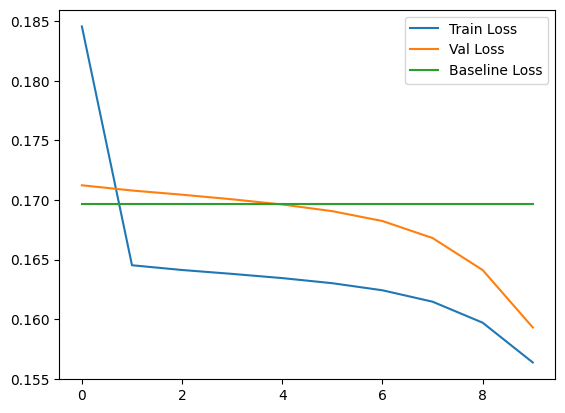

Test Loss:  0.1364329561637112


In [53]:
def train_elmon(model, X_train, Y_train, X_val, Y_val, num_epochs=50):
    loss = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.0001)

    best_val_loss = float('inf')
    best_model = None
    train_loss_list = []
    val_lost_list = []
    
    for epoch in range(num_epochs):
        epoch_train_loss = 0
        epoch_val_loss = 0

        # Training
        model.train()
        for j in range(len(X_train)):
            x = torch.from_numpy(X_train[j]).float()
            y = torch.from_numpy(np.array(Y_train[j])).float()
            y = y.view(1, 1)
            hidden_out = torch.zeros(3)
            total_loss = 0
            optimizer.zero_grad()
            for k in range(x.shape[1]):
                hidden_out2 = model.hidden_forward(x[:, k], hidden_out)
                y_pred = model.pred_forward(hidden_out2)
                y_true = torch.dot(x[0, :(k+1)], x[1, :(k+1)])
                # loss_val = loss(y_pred, y_true)
                # total_loss += loss_val
                
                # loss_val.backward(retain_graph=True)
                # optimizer.step()
                hidden_out = hidden_out2
            # loss_val = loss(y_pred, y_true)
            loss_val = loss(y_pred, y)
            loss_val.backward(retain_graph=True)
            optimizer.step()
            total_loss = loss_val.item()
            epoch_train_loss += total_loss


        # Validation
        with torch.no_grad():
            model.eval()
            # print("Training: ", model.training)
            for i in range(len(X_val)):
                x = torch.from_numpy(X_val[i]).float()
                y = torch.from_numpy(np.array(Y_val[i])).float()
                y = y.view(1, 1)
                hidden_out = torch.zeros(3)
                total_loss = 0
                pred_val = 0

                for k in range(x.shape[1]):
                    hidden_out2 = model.hidden_forward(x[:, k], hidden_out)
                    y_pred = model.pred_forward(hidden_out2)
                    pred_val = y_pred
                    # y_true = torch.dot(x[0, :(k+1)], x[1, :(k+1)])
                    # loss_val = loss(y_pred, y_true)
                    # total_loss += loss_val
                    hidden_out = hidden_out2
                total_loss = loss(pred_val, y)
                epoch_val_loss += total_loss

            # Save best model
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                best_model = model.state_dict()
                torch.save(best_model, "best_model.pt")

        # Print loss for current epoch
        print(f"Epoch {epoch+1} Train Loss: {epoch_train_loss:.4f} Val Loss: {epoch_val_loss:.4f} Avg Train Loss: {epoch_train_loss/len(X_train):.4f} Avg Val Loss: {epoch_val_loss/len(X_val):.4f}")
        train_loss_list.append(epoch_train_loss/len(X_train))
        val_lost_list.append(epoch_val_loss/len(X_val))

    # Load best model
    model.load_state_dict(best_model)

    # # Print all the weights and biases
    # print(model.fc1.weight)
    # print(model.fc1.bias)
    # # print(model.fc2.weight)
    # # print(model.fc2.bias)
    # print(model.hidden_weight.weight)
    # print(model.hidden_weight.bias)
    # print(model.pred_weight.weight)
    # print(model.pred_weight.bias)

    return model, train_loss_list, val_lost_list

elmon_model = ElmonNet()
# print(X_train, Y_train, X_test, Y_test)
num_epochs = 10
best_model, train_lost_list, val_loss_list = train_elmon(elmon_model, X_train, Y_train, X_val, Y_val, num_epochs=num_epochs) 
best_model.eval()
# test the model
loss = nn.MSELoss()
min_y_test = min(Y_test)
max_y_test = max(Y_test)
min_y_pred = 2
max_y_pred = 0

# Plot the loss
plt.plot(train_lost_list, label="Train Loss")
plt.plot(val_loss_list, label="Val Loss")
# plot baseline loss 
plt.plot(np.arange(num_epochs), avg_baseline_loss*np.ones(num_epochs), label="Baseline Loss")
plt.legend()
plt.show()
plt.close()

test_loss = 0
for i in range(len(X_test)):
    x = torch.from_numpy(X_test[i]).float()
    y = torch.from_numpy(np.array(Y_test[i])).float()
    y = y.view(1, 1)
    hidden_out = torch.zeros(3)
    total_loss = 0
    pred_val = 0

    for k in range(x.shape[1]):
        hidden_out2 = best_model.hidden_forward(x[:, k], hidden_out)
        y_pred = best_model.pred_forward(hidden_out2)
        pred_val = y_pred
        y_true = torch.dot(x[0, :(k+1)], x[1, :(k+1)])
        # loss_val = loss(y_pred, y_true)
        # total_loss += loss_val
        hidden_out = hidden_out2
    total_loss = loss(pred_val, y)
    test_loss += total_loss.item()
    if pred_val > max_y_pred:
        max_y_pred = pred_val
    if pred_val < min_y_pred:
        min_y_pred = pred_val
#     print("For sample: Y_pred: ", pred_val, " Y_test: ", y, " Loss: ", total_loss)

print("Test Loss: ", test_loss/len(X_test))


# print("Min Y_pred: ", min_y_pred, " Max Y_pred: ", max_y_pred)
# print("Min Y_test: ", min_y_test, " Max Y_test: ", max_y_test)

## LSTM

In [54]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.forget_weight = nn.Linear(input_size + hidden_size, self.hidden_size)
        self.input_weight = nn.Linear(input_size + hidden_size, self.hidden_size)
        self.candidate_weight = nn.Linear(input_size + hidden_size, self.hidden_size)
        self.output_weight = nn.Linear(input_size + hidden_size, self.hidden_size)
        self.hidden_state = torch.zeros(self.hidden_size)
        self.cell_state = torch.zeros(self.hidden_size)
        self.pred_weight = nn.Linear(hidden_size, 1)
        
    def forget_gate(self, x):
        # print(x.shape, self.hidden_state.shape)
        out = torch.cat((x, self.hidden_state), axis=0)
        return torch.sigmoid(self.forget_weight(out))
        
    def input_gate(self, x):
        out = torch.cat((x, self.hidden_state), axis=0)
        i_t = torch.sigmoid(self.input_weight(out))
        C_tilda_t = torch.tanh(self.candidate_weight(out))
        return torch.multiply(i_t, C_tilda_t)
        
    def output_gate(self, x):
        out = torch.cat((x, self.hidden_state), axis=0)
        return torch.sigmoid(self.output_weight(out))
    
    def forward(self, x):
        f_t = self.forget_gate(x)
        i_t_C_tilda_t = self.input_gate(x)
        o_t = self.output_gate(x)
        C_t = torch.add(torch.multiply(f_t, self.cell_state), i_t_C_tilda_t)
        h_t = torch.multiply(o_t, torch.tanh(C_t))
        
        self.hidden_state = h_t
        self.cell_state = C_t

        return h_t
    
    def pred_forward(self):
        return self.pred_weight(self.hidden_state)
        
def train_lstm(model, X_train, Y_train, X_val, Y_val, num_epochs=100):
    # Set model to training mode
    model.train()
    # Set optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # Set loss function
    loss = nn.MSELoss()
    # Set best validation loss to infinity
    best_val_loss = float("inf")
    train_lstm_list = []
    val_lstm_list = []

    for epoch in range(num_epochs):
        # Set initial loss to 0
        epoch_train_loss = 0
        epoch_val_loss = 0

        # Train model
        model.train()
        
        for i in range(len(X_train)):
            x = torch.from_numpy(X_train[i]).float()
            y = torch.from_numpy(np.array(Y_train[i])).float()
            y = y.view(1, 1)
            model.hidden_state = torch.zeros(model.hidden_size)
            model.cell_state = torch.zeros(model.hidden_size)
            # hidden_out = torch.zeros(1, model.hidden_size)
            total_loss = 0
            pred_val = 0
            optimizer.zero_grad()

            for k in range(x.shape[1]):
                model.forward(x[:, k])
                y_pred = model.pred_forward()
                pred_val = y_pred
                # y_true = torch.dot(x[0, :(k+1)], x[1, :(k+1)])
                # loss_val = loss(y_pred, y_true)
                # total_loss += loss_val
                # hidden_out = hidden_out2
            loss_val = loss(pred_val, y)
            loss_val.backward(retain_graph=True)
            optimizer.step()
            epoch_train_loss += loss_val.item()
            
        # Validate model
        model.eval()
        for i in range(len(X_val)):
            x = torch.from_numpy(X_val[i]).float()
            y = torch.from_numpy(np.array(Y_val[i])).float()
            y = y.view(1, 1)
            model.hidden_state = torch.zeros(model.hidden_size)
            model.cell_state = torch.zeros(model.hidden_size)
            # hidden_out = torch.zeros(1, model.hidden_size)
            total_loss = 0
            pred_val = 0

            for k in range(x.shape[1]):
                model.forward(x[:, k])
                y_pred = model.pred_forward()
                pred_val = y_pred
                # y_true = torch.dot(x[0, :(k+1)], x[1, :(k+1)])
                # loss_val = loss(y_pred, y_true)
                # total_loss += loss_val
                # hidden_out = hidden_out2
            total_loss = loss(pred_val, y)
            total_loss = total_loss.item()
            epoch_val_loss += total_loss
        
        # Calculate average loss
        epoch_train_loss /= len(X_train)
        epoch_val_loss /= len(X_val)
    
        # Save best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model = model.state_dict()
            torch.save(best_model, "best_model_lstm.pt")
        
        # Print loss
        # print("Epoch: ", epoch, " Train loss: ", epoch_train_loss, " Val loss: ", epoch_val_loss)
        print(f"Epoch {epoch+1} Train Loss: {epoch_train_loss * len(X_train):.4f} Val Loss: {epoch_val_loss * len(X_val):.4f} Avg Train Loss: {epoch_train_loss:.4f} Avg Val Loss: {epoch_val_loss:.4f}")
        train_lstm_list.append(epoch_train_loss)
        val_lstm_list.append(epoch_val_loss)
    model.load_state_dict(torch.load("best_model_lstm.pt"))
    
    return model, train_lstm_list, val_lstm_list


Epoch 1 Train Loss: 646.5583 Val Loss: 82.7614 Avg Train Loss: 0.1293 Avg Val Loss: 0.0828
Epoch 2 Train Loss: 91.7036 Val Loss: 8.0053 Avg Train Loss: 0.0183 Avg Val Loss: 0.0080
Epoch 3 Train Loss: 14.4565 Val Loss: 1.2428 Avg Train Loss: 0.0029 Avg Val Loss: 0.0012
Epoch 4 Train Loss: 5.8255 Val Loss: 0.6809 Avg Train Loss: 0.0012 Avg Val Loss: 0.0007
Epoch 5 Train Loss: 3.1281 Val Loss: 0.3685 Avg Train Loss: 0.0006 Avg Val Loss: 0.0004
Epoch 6 Train Loss: 2.2463 Val Loss: 0.2954 Avg Train Loss: 0.0004 Avg Val Loss: 0.0003
Epoch 7 Train Loss: 1.8557 Val Loss: 0.2414 Avg Train Loss: 0.0004 Avg Val Loss: 0.0002
Epoch 8 Train Loss: 1.6097 Val Loss: 0.1935 Avg Train Loss: 0.0003 Avg Val Loss: 0.0002
Epoch 9 Train Loss: 1.4303 Val Loss: 0.1579 Avg Train Loss: 0.0003 Avg Val Loss: 0.0002
Epoch 10 Train Loss: 1.2847 Val Loss: 0.1367 Avg Train Loss: 0.0003 Avg Val Loss: 0.0001


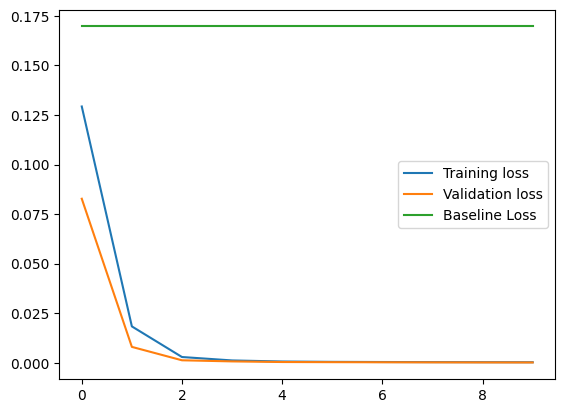

Test loss:  0.00011993445221463616


In [56]:
lstm_model = LSTM(2, 10)
lstm_model, train_lstm_list, val_lstm_list = train_lstm(lstm_model, X_train, Y_train, X_val, Y_val, num_epochs=10)
lstm_model.eval()
loss = nn.MSELoss()
min_y_pred = float("inf")
max_y_pred = 0
min_y_test = min(Y_test)
max_y_test = max(Y_test)

# Plot training and validation loss
plt.plot(train_lstm_list, label="Training loss")
plt.plot(val_lstm_list, label="Validation loss")
plt.plot(np.arange(num_epochs), avg_baseline_loss*np.ones(num_epochs), label="Baseline Loss")
plt.legend()
plt.show()
plt.close()

test_loss_lstm = 0
for i in range(len(X_test)):
    x = torch.from_numpy(X_test[i]).float()
    y = torch.from_numpy(np.array(Y_test[i])).float()
    y = y.view(1, 1)
    hidden_out = torch.zeros(lstm_model.hidden_size)
    total_loss = 0
    pred_val = 0
    lstm_model.hidden_state = torch.zeros(lstm_model.hidden_size)
    lstm_model.cell_state = torch.zeros(lstm_model.hidden_size)

    for k in range(x.shape[1]):
        hidden_out2 = lstm_model.forward(x[:, k])
        y_pred = lstm_model.pred_forward()
        pred_val = y_pred
        # y_true = torch.dot(x[0, :(k+1)], x[1, :(k+1)])
        # loss_val = loss(y_pred, y_true)
        # total_loss += loss_val
        # hidden_out = hidden_out2
    total_loss = loss(pred_val, y)
    total_loss = total_loss.item()
    test_loss_lstm += total_loss
    if y_pred < min_y_pred:
        min_y_pred = y_pred
    if y_pred > max_y_pred:
        max_y_pred = y_pred
#     print("For sample: Y_pred: ", pred_val, " Y_test: ", y, " Loss: ", total_loss)
    
# print("Min y_pred: ", min_y_pred.item(), " Max y_pred: ", max_y_pred.item(), " Min y_test: ", min_y_test.item(), " Max y_test: ", max_y_test.item())
print("Test loss: ", test_loss_lstm/len(X_test))



## GRU

In [57]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        
        self.W_z = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_r = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_h_tilda = nn.Linear(input_size + hidden_size, hidden_size)
        self.pred_weight = nn.Linear(hidden_size, 1)
        
        self.hidden_state = torch.zeros(self.hidden_size)
        
    def z_t_forward(self, x):
        out = torch.sigmoid(self.W_z(torch.cat((x, self.hidden_state), 0)))
        return out
    
    def r_t_forward(self, x):
        out = torch.sigmoid(self.W_r(torch.cat((x, self.hidden_state), 0)))
        return out
    
    def h_tilda_t_forward(self, x):
        out = torch.tanh(self.W_h_tilda(torch.cat((x, self.r_t_forward(x) * self.hidden_state), 0)))
        return out
    
    def forward(self, x):
        z_t = self.z_t_forward(x)
        h_tilda_t = self.h_tilda_t_forward(x)
        self.hidden_state = (1 - z_t) * self.hidden_state + z_t * h_tilda_t
        return self.hidden_state
    
    def pred_forward(self):
        out = self.pred_weight(self.hidden_state)
        return out
    
def train_gru(model, X_train, Y_train, X_val, Y_val, num_epochs=10):
    train_gru_list = []
    val_gru_list = []
    best_model = None
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float("inf")
    for epoch in range(num_epochs):
        epoch_train_loss = 0
        epoch_val_loss = 0
        model.train()
        for i in range(len(X_train)):
            x = torch.from_numpy(X_train[i]).float()
            y = torch.from_numpy(np.array(Y_train[i])).float()
            y = y.view(1, 1)
            hidden_out = torch.zeros(model.hidden_size)
            total_loss = 0
            pred_val = 0
            model.hidden_state = torch.zeros(model.hidden_size)
            optimizer.zero_grad()
            for k in range(x.shape[1]):
                hidden_out2 = model.forward(x[:, k])
                y_pred = model.pred_forward()
                pred_val = y_pred
                # y_true = torch.dot(x[0, :(k+1)], x[1, :(k+1)])
                # loss_val = loss(y_pred, y_true)
                # total_loss += loss_val
                # hidden_out = hidden_out2
            total_loss = loss(pred_val, y)
            total_loss.backward()
            optimizer.step()
            total_loss = total_loss.item()
            epoch_train_loss += total_loss
        
        model.eval()
        for i in range(len(X_val)):
            x = torch.from_numpy(X_val[i]).float()
            y = torch.from_numpy(np.array(Y_val[i])).float()
            y = y.view(1, 1)
            hidden_out = torch.zeros(model.hidden_size)
            total_loss = 0
            pred_val = 0
            model.hidden_state = torch.zeros(model.hidden_size)
            for k in range(x.shape[1]):
                hidden_out2 = model.forward(x[:, k])
                y_pred = model.pred_forward()
                pred_val = y_pred
                # y_true = torch.dot(x[0, :(k+1)], x[1, :(k+1)])
                # loss_val = loss(y_pred, y_true)
                # total_loss += loss_val
                # hidden_out = hidden_out2
            total_loss = loss(pred_val, y)
            total_loss = total_loss.item()
            epoch_val_loss += total_loss
        
        # Calculate average loss
        epoch_train_loss /= len(X_train)
        epoch_val_loss /= len(X_val)
        train_gru_list.append(epoch_train_loss)
        val_gru_list.append(epoch_val_loss)
    
        # Save the best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model = model
            torch.save(model.state_dict(), "best_gru_model.pt")
    
        print(f"Epoch {epoch+1} Train Loss: {epoch_train_loss * len(X_train):.4f} Val Loss: {epoch_val_loss * len(X_val):.4f} Avg Train Loss: {epoch_train_loss:.4f} Avg Val Loss: {epoch_val_loss:.4f}")
        
    return train_gru_list, val_gru_list, best_model

Epoch 1 Train Loss: 626.0205 Val Loss: 19.0970 Avg Train Loss: 0.1252 Avg Val Loss: 0.0191
Epoch 2 Train Loss: 25.4086 Val Loss: 2.1112 Avg Train Loss: 0.0051 Avg Val Loss: 0.0021
Epoch 3 Train Loss: 4.5226 Val Loss: 0.3784 Avg Train Loss: 0.0009 Avg Val Loss: 0.0004
Epoch 4 Train Loss: 1.7312 Val Loss: 0.1628 Avg Train Loss: 0.0003 Avg Val Loss: 0.0002
Epoch 5 Train Loss: 1.1221 Val Loss: 0.1279 Avg Train Loss: 0.0002 Avg Val Loss: 0.0001
Epoch 6 Train Loss: 0.9280 Val Loss: 0.1193 Avg Train Loss: 0.0002 Avg Val Loss: 0.0001
Epoch 7 Train Loss: 0.8219 Val Loss: 0.1126 Avg Train Loss: 0.0002 Avg Val Loss: 0.0001
Epoch 8 Train Loss: 0.7479 Val Loss: 0.1092 Avg Train Loss: 0.0001 Avg Val Loss: 0.0001
Epoch 9 Train Loss: 0.6901 Val Loss: 0.1082 Avg Train Loss: 0.0001 Avg Val Loss: 0.0001
Epoch 10 Train Loss: 0.6419 Val Loss: 0.1085 Avg Train Loss: 0.0001 Avg Val Loss: 0.0001


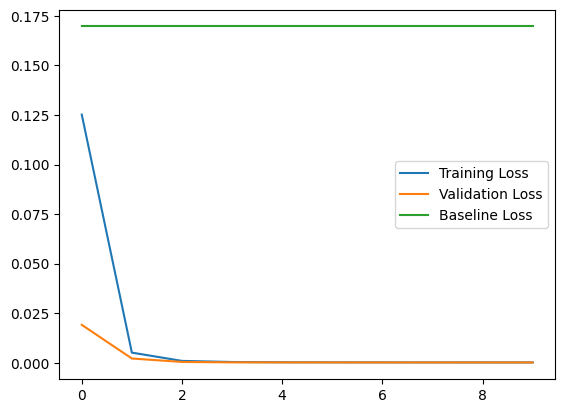

Test Loss:  9.916752150175512e-05


In [58]:
gru_model = GRU(2, 10)
num_epochs = 10
train_gru_list, val_gru_list, gru_model = train_gru(gru_model, X_train, Y_train, X_val, Y_val, num_epochs=num_epochs)
gru_model.eval()
loss = nn.MSELoss()
min_y_pred = float("inf")
max_y_pred = 0
min_y_test = min(Y_test)
max_y_test = max(Y_test)

# Plot the training and validation loss
plt.plot(train_gru_list, label="Training Loss")
plt.plot(val_gru_list, label="Validation Loss")
plt.plot(np.arange(num_epochs), avg_baseline_loss*np.ones(num_epochs), label="Baseline Loss")
plt.legend()
plt.show()

test_loss_gru = 0
for i in range(len(X_test)):
    x = torch.from_numpy(X_test[i]).float()
    y = torch.from_numpy(np.array(Y_test[i])).float()
    y = y.view(1, 1)
    hidden_out = torch.zeros(gru_model.hidden_size)
    total_loss = 0
    pred_val = 0
    gru_model.hidden_state = torch.zeros(gru_model.hidden_size)
    for k in range(x.shape[1]):
        hidden_out2 = gru_model.forward(x[:, k])
        y_pred = gru_model.pred_forward()
        pred_val = y_pred
        # y_true = torch.dot(x[0, :(k+1)], x[1, :(k+1)])
        # loss_val = loss(y_pred, y_true)
        # total_loss += loss_val
        # hidden_out = hidden_out2
    total_loss = loss(pred_val, y)
    total_loss = total_loss.item()
    test_loss_gru += total_loss
    if pred_val < min_y_pred:
        min_y_pred = pred_val
    if pred_val > max_y_pred:
        max_y_pred = pred_val
#         print("For sample: Y_pred: ", pred_val, " Y_test: ", y, " Loss: ", total_loss)

# print("Min y_pred: ", min_y_pred.item(), " Max y_pred: ", max_y_pred.item(), " Min y_test: ", min_y_test.item(), " Max y_test: ", max_y_test.item())
print("Test Loss: ", test_loss_gru/len(X_test))


## Plotting the Results

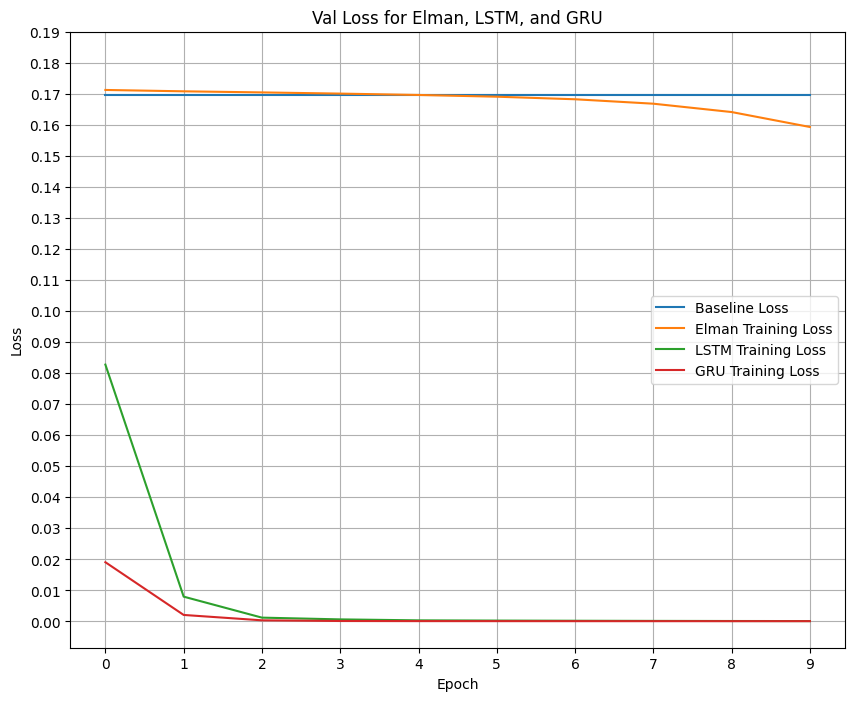

In [59]:
# Plot validation for baseline, Elman, LSTM, and GRU
plt.figure(figsize=(10, 8))
plt.plot(np.arange(num_epochs), avg_baseline_loss*np.ones(num_epochs), label="Baseline Loss")
plt.plot(val_loss_list, label="Elman Training Loss")
plt.plot(val_lstm_list, label="LSTM Training Loss")
plt.plot(val_gru_list, label="GRU Training Loss")
plt.xticks(np.arange(num_epochs))
plt.yticks(np.arange(0, 0.2, 0.01))
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Val Loss for Elman, LSTM, and GRU")
plt.legend()
plt.show()


## Plotting for Test Data

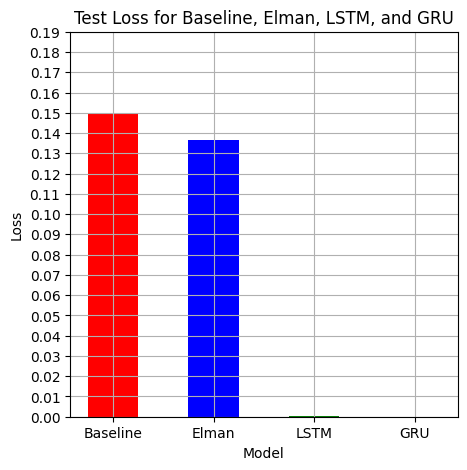

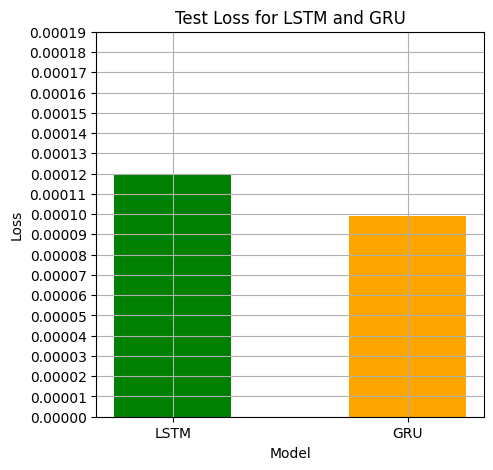

In [63]:
# Plot the test loss values for baseline, Elman, LSTM, and GRU
plt.figure(figsize=(5, 5))
plt.bar(["Baseline", "Elman", "LSTM", "GRU"], 
        [avg_baseline_loss_test, test_loss/len(X_test), test_loss_lstm/len(X_test), test_loss_gru/len(X_test)]
        , width=0.5, color=["red", "blue", "green", "orange"])
plt.yticks(np.arange(0, 0.2, 0.01))
plt.grid()
plt.xlabel("Model")
plt.ylabel("Loss")
plt.title("Test Loss for Baseline, Elman, LSTM, and GRU")
plt.show()

# Plot the test loss values for LSTM, and GRU
plt.figure(figsize=(5, 5))
plt.bar(["LSTM", "GRU"],
        [test_loss_lstm/len(X_test), test_loss_gru/len(X_test)]
        , width=0.5, color=["green", "orange"])
plt.yticks(np.arange(0, 0.0002, 0.00001))
plt.grid()
plt.xlabel("Model")
plt.ylabel("Loss")
plt.title("Test Loss for LSTM and GRU")
plt.show()